In [1336]:
import pandas as pd
import numpy as np
import nltk
import os
import nltk.corpus
import glob


In [1337]:
from pathlib import Path
# change these to the directory where you cloned openvirusdev
HOME = str(Path.home())
OPENVIRUSDEV = HOME + "/" + "workspace/openvirusdev"
PROJECTS = HOME + "/" + "projects"


In [1338]:
# PMR's projects. 
IPYNB = OPENVIRUSDEV + "/" + "ipynb"
VIRUS2019 = OPENVIRUSDEV + "/" + "viral2019"

OPENBATTERY = PROJECTS + "/" + "open-battery"
LIION = OPENBATTERY + "/" + "liion"



In [1339]:
def get_section_globs():
    section_globs = {}

    section_globs["abstract"]  = ("abstract",   '**/sections/**/*abstract*.xml')
    section_globs["abstract1"] = ("abstract1"), '**/sections/**/*abstract*/*.xml'
    section_globs["method"]    = ("method",     '**/sections/**/*method*/*.xml')
    section_globs["all"]       = ("all",        '**/sections/**/*.xml')
    section_globs["figure"]    = ("figure",     '**/sections/**/*figure*.xml')
    section_globs["table"]     = ("table",      '**/sections/**/*table*.xml')
    section_globs["reflist"]   = ("ref-list",    '**/sections/**/*ref-list*/*.xml')

    return section_globs

In [1340]:
def get_globbed_files(directory, file_glob, recurse=True):
    """
    returns a list of files satisfying the file_glob expression
    in the context of dir
    temporarily changes directory and then resets to current dir
    recurses through the directory if recursive = True (default)    
    """
    current_dir = os.getcwd()
    os.chdir(directory)
    files = glob.glob(file_glob, recursive=recurse)
#    print("number of " + file_glob + " files in " + directory + ": " + str(len(files)))
    os.chdir(current_dir)
    return files

In [1341]:
def get_or_create_section_dirs():
    section_dirs = get_globbed_files(project, '**/sections')
    if (len(section_dirs) == 0):
        cmd = "ami -v -p " + project + " section"
        print("running: "+cmd)
        ! $cmd
        section_dirs = get_globbed_files(project, '**/sections')
        print("found: " + section_dirs)

    

In [1342]:

def get_glob_dict0():
    return get_glob_dict(get_section_globs())

def get_glob_dict(section_globs):
    
    glob_dict = {}
    for key in section_globs:
        glob = section_globs[key]
        glob_dict[key] = glob
        
    return glob_dict


In [1343]:
def read_text_contents(text_files):
    os.chdir(project)

    text_contents = []
    for text_file in text_files:
        text_filex = open(text_file,mode='r')
        text = text_filex.read()
        text_filex.close()
        text_contents.append(text)

    return text_contents


In [1344]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
import re

def remove_xml_punkt_tokenize_stopwords(text_contents, minlen=2, lang='english'):
    nltk.download('stopwords')

    stop_en = set(stopwords.words(lang))
    stop_sci = get_stopwords_sci();

    # filter words
    content_words_list = []
    for text_content in text_contents:
        # remove (most) XML markup
        text_content1 = re.sub('</?[^>]*>', '', text_content)
        words = word_tokenize(text_content1)
        # remove stopwords, punctuation, and short words
        words = [w for w in words \
                  if w.lower() not in stop_en \
                  and w not in stop_sci\
                  and w not in string.punctuation\
                  and not matches_noise(w)\
                  and len(w) >= minlen
                 ]

        content_words_list.append(words)

    content_words = [word for lizt in content_words_list for word in lizt]
    return content_words

def matches_noise(word):
    return matches("\-?\d+|[A-Z]\.|et|al", word)
    
def matches(regex_str, word):
    regex = re.compile(regex_str)
    match = regex.fullmatch(word)
#    print("noise " + word +", "+str(match))
    return not match == None

def get_stopwords_sci():
    words =['et', 'al', 'J.']
    return set(words)

[nltk_data] Downloading package punkt to /Users/pm286/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [1345]:
def analyze_frequencies_all():
    for section in get_glob_dict0():
        analyze_frequencies0(section)
        

In [1346]:
def analyze_frequencies0(section):
    glob_expr = get_glob_dict0()[section][1]
    print("glob " + glob_expr)
    files = get_globbed_files(project, glob_expr)
    analyze_frequencies(files, section)
    print("files " + str(len(files)))

In [1347]:
def analyze_frequencies(files, title):
    text_contents = read_text_contents(files)
    words = remove_xml_punkt_tokenize_stopwords(text_contents)
    plot_frequency(words, title)

In [1348]:
from nltk.probability import FreqDist
import matplotlib.pyplot as plt

def plot_frequency(words, title="title"):
    fdist = FreqDist(words)
    print(fdist.most_common(30))
    fdist.plot(30, title=title)


In [1349]:
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer 

def stem_lemmatize(words, stemmer=PorterStemmer(), lemmatizer=WordNetLemmatizer()):

    stemmed = []
    for word in words :
        if (stemmer != None):
            word1 = stemmer.stem(word)
        elif (lemmatizer != None):
            word1 = lemmatizer.lemmatize(word)
        stemmed.append(word1)
    return stemmed
    


In [1350]:
from nltk import ne_chunk

def chunk(text):    
    nltk.download('maxent_ne_chunker')
    nltk.download('words')
    # tokenize and POS Tagging before doing chunk
    tokens = word_tokenize(text)
    tags = nltk.pos_tag(tokens)
    chunk = ne_chunk(tags)
    return chunk


In [1351]:
def noun_phrase(text):
    tokens = word_tokenize(text)
    tags = nltk.pos_tag(tokens)
    reg = "NP: {<DT>?<JJ>*<NN>}" 
    parser = nltk.RegexpParser(reg)
    np_tree = parser.parse(tags)
    return np_tree

In [1352]:
def count_vectorize():
    """
    not tested
    """
    from sklearn.feature_extraction.text import CountVectorizer
    from nltk.tokenize import RegexpTokenizer
    #tokenizer to remove unwanted elements from out data like symbols and numbers
    token = RegexpTokenizer(r'[a-zA-Z0-9]+')
    cv = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)


In [1353]:
def sentence_tokenizer(text):
    from nltk.tokenize import sent_tokenize
    sentences=sent_tokenize(text)
    print("sentences: "+str(len(sentences)))
    for sentence in sentences:
        print(">> "+sentence+"\n..")
        phrases = sentence.split("\n")
        print("??"+str(len(phrases)))


In [1354]:
def tfidfVector():
    """
    not tested
    """
    from sklearn.feature_extraction.text import TfidfVectorizer
    tf=TfidfVectorizer()
    # text_tf= tf.fit_transform(data['Phrase'])
    text_tf= tf.fit_transform(phrases)

In [1355]:
def tfidf():
    """
    not tested
    """
    import pandas as pd 
    from sklearn.feature_extraction.text import TfidfTransformer
    from sklearn.feature_extraction.text import CountVectorizer
    cv=CountVectorizer() 
    word_count_vector=cv.fit_transform(sentences)
    tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
    tfidf_transformer.fit(word_count_vector)
    # print idf values 
    df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 

    # sort ascending 
    df_idf.sort_values(by=['idf_weights'])

In [1356]:
# ==================
# from scikit-learn
# https://scikit-learn.org/stable/auto_examples/bicluster/plot_bicluster_newsgroups.html#sphx-glr-auto-examples-bicluster-plot-bicluster-newsgroups-py
# ==================

glob **/sections/**/*abstract*.xml


[nltk_data] Downloading package stopwords to /Users/pm286/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('COVID-19', 269), ('epidemic', 153), ('patients', 143), ('cases', 118), ('viral', 117), ('disease', 110), ('infection', 106), ('virus', 100), ('SARS-CoV-2', 100), ('coronavirus', 82), ('China', 81), ('HIV', 80), ('transmission', 75), ('spread', 70), ('respiratory', 68), ('health', 67), ('clinical', 65), ('outbreak', 63), ('dengue', 60), ('pandemic', 57), ('study', 56), ('model', 55), ('time', 54), ('severe', 53), ('control', 51), ('infections', 50), ('ART', 50), ('including', 49), ('data', 47), ('treatment', 45)]


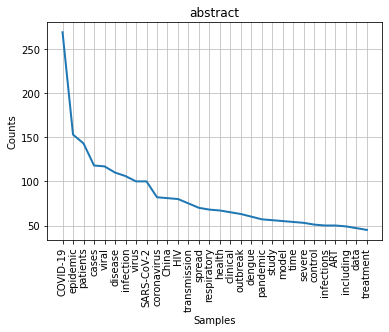

files 186
glob **/sections/**/*abstract*/*.xml
[]


[nltk_data] Downloading package stopwords to /Users/pm286/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


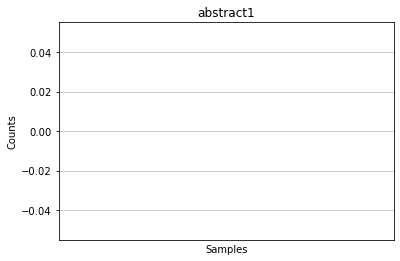

files 0
glob **/sections/**/*method*/*.xml


[nltk_data] Downloading package stopwords to /Users/pm286/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('using', 53), ('data', 51), ('HIV', 46), ('Methods', 44), ('used', 44), ('COVID-19', 43), ('model', 38), ('time', 38), ('viral', 37), ('SARS-CoV-2', 32), ('analysis', 29), ('infection', 29), ('study', 28), ('included', 26), ('health', 25), ('methods', 24), ('number', 24), ('also', 24), ('system', 24), ('results', 24), ('disease', 23), ('Materials', 21), ('epidemic', 21), ('values', 21), ('following', 21), ('performed', 21), ('population', 21), ('test', 21), ('ART', 20), ('case', 20)]


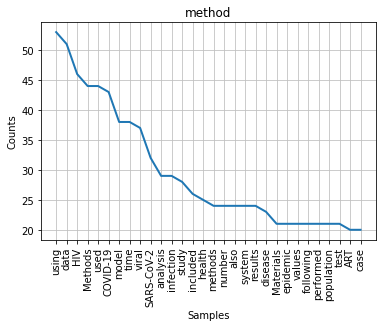

files 199
glob **/sections/**/*.xml


[nltk_data] Downloading package stopwords to /Users/pm286/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('COVID-19', 3734), ('patients', 2391), ('virus', 2295), ('infection', 1954), ('cases', 1917), ('China', 1902), ('epidemic', 1871), ('viral', 1776), ('HIV', 1655), ('disease', 1625), ('coronavirus', 1572), ('study', 1477), ('SARS-CoV-2', 1310), ('transmission', 1302), ('data', 1240), ('Health', 1195), ('health', 1112), ('number', 1076), ('also', 1054), ('respiratory', 1043), ('al.', 964), ('time', 957), ('analysis', 912), ('human', 891), ('may', 889), ('\\usepackage', 882), ('population', 879), ('treatment', 875), ('https', 873), ('clinical', 857)]


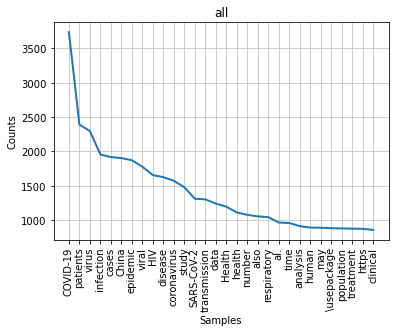

files 17144
glob **/sections/**/*figure*.xml


[nltk_data] Downloading package stopwords to /Users/pm286/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('Fig', 211), ('Figure', 164), ('COVID-19', 80), ('number', 79), ('cases', 75), ('China', 62), ('days', 58), ('values', 55), ('February', 54), ('CT', 46), ('line', 44), ('virus', 43), ('distribution', 41), ('viral', 40), ('years', 40), ('March', 40), ('blue', 39), ('red', 39), ('HIV', 37), ('time', 37), ('epidemic', 36), ('infected', 36), ('model', 36), ('infection', 36), ('human', 35), ('January', 35), ('sequences', 35), ('dengue', 34), ('show', 33), ('deaths', 32)]


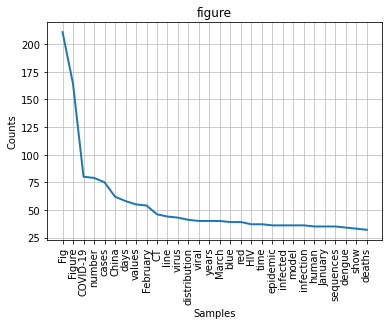

files 310
glob **/sections/**/*table*.xml


[nltk_data] Downloading package stopwords to /Users/pm286/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('Table', 256), ('lt', 236), ('cases', 113), ('infection', 109), ('RV', 105), ('HIV', 102), ('0.001', 102), ('COVID-19', 101), ('virus', 95), ('days', 88), ('viral', 80), ('gt', 77), ('range', 76), ('IQR', 76), ('RSV', 72), ('rate', 71), ('Total', 70), ('patients', 70), ('years', 67), ('disease', 66), ('respiratory', 65), ('clinical', 63), ('transmission', 63), ('coronavirus', 63), ('without', 59), ('children', 59), ('Yes', 58), ('CI', 57), ('diagnosis', 56), ('\\usepackage', 56)]


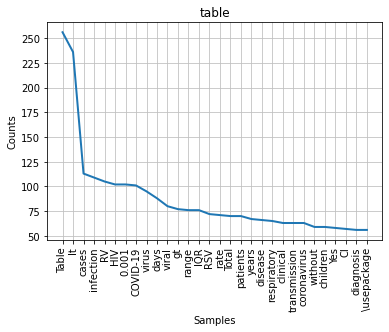

files 221
glob **/sections/**/*ref-list*/*.xml


[nltk_data] Downloading package stopwords to /Users/pm286/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('COVID-19', 902), ('coronavirus', 842), ('Med', 771), ('virus', 732), ('https', 587), ('China', 579), ('Infect', 574), ('Dis', 563), ('Wang', 516), ('Health', 500), ('Li', 468), ('novel', 432), ('HIV', 426), ('infection', 410), ('disease', 404), ('Zhang', 392), ('patients', 380), ('Lancet', 376), ('Available', 364), ('Liu', 343), ('epidemic', 321), ('Accessed', 307), ('Virol', 299), ('study', 297), ('SARS-CoV-2', 287), ('respiratory', 281), ('transmission', 272), ('Clin', 268), ('Chen', 263), ('outbreak', 255)]


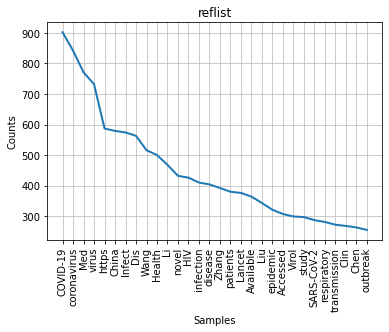

files 6201


'\nregex = re.compile(\'xyz|\\-?\\d+\')\nfor a in [\'xyz\', \'J.\', \'-10\', \'et\', \'23\', \'kjsdb\']:\n    print("===")\n    if matches_noise(a):\n        print("noise: " + a)\n'

In [1357]:
# MAIN ENTRY

project = VIRUS2019
# project = LIION

os.chdir(project)

# analyze_frequencies0('abstract')
analyze_frequencies_all();
